## Student Name: 
Dara Corr

## Student ID:
22275193

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [1]:
!pip install scikit-optimize
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [2]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [32]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [33]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_errors = 1- train_scores
    test_errors = 1-test_scores
    
    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")

    
    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [35]:
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [36]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=100,
)

In [37]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=100,
)

# Solutions

## Task 1

In [11]:
df1 = pd.read_csv('dataset_1_train.csv', names = ['x1','x2','y'])
df1.head()

,x1,x2,y
0,0.913385,-0.131071,1.0
1,-1.393895,-1.373790,0.0
2,-0.379568,1.404829,0.0
3,1.525722,-1.713379,1.0
4,1.444181,-0.622548,1.0


In [12]:
y = df1['y'].to_numpy()
X = df1[['x1', 'x2']].to_numpy()

#use all data for training in this task, so no need to split into testing and training
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=555)

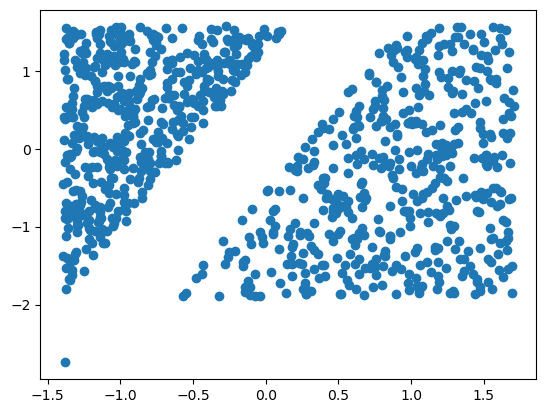

In [13]:
plt.plot(df1['x1'], df1['x2'],'o')

In [14]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X, y)

#Predict the response for test dataset
y_pred = clf.predict(X)

Accuracy: 0.999000999000999


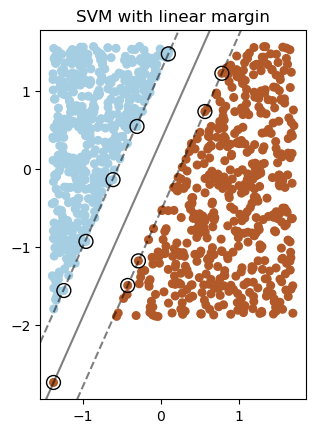

In [15]:
plot_margin(X, y, clf)
plt.title("SVM with linear margin")

print("Accuracy:",metrics.accuracy_score(y, y_pred))

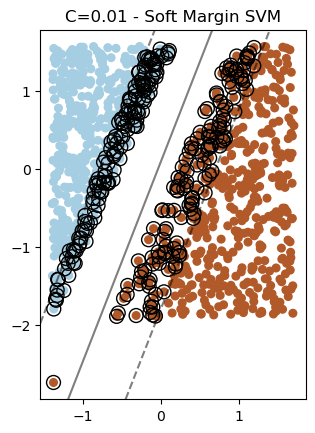

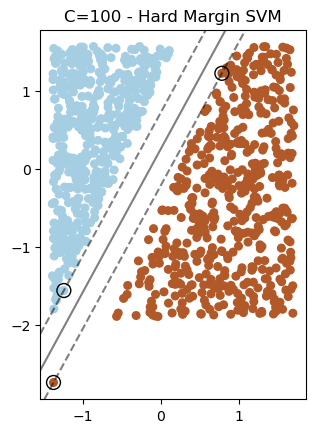

In [16]:
clf1 = svm.SVC(kernel='linear', C=0.01)
clf1.fit(X, y)
y_pred1 = clf1.predict(X)
plot_margin(X, y, clf1)
plt.title("C=0.01 - Soft Margin SVM")
plt.show()

clf2 = svm.SVC(kernel='linear', C=1)
clf2.fit(X, y)
y_pred2 = clf1.predict(X)
#plot_margin(X, y, clf2)
#plt.title("C=1")
#plt.show()

clf3 = svm.SVC(kernel='linear', C=100)
clf3.fit(X, y)
y_pred3 = clf1.predict(X)
plot_margin(X, y, clf3)
plt.title("C=100 - Hard Margin SVM")
plt.show()


## Reflection

The value C is a regularisation parameter for SVM models. In contrast to the Regularisation parameter $\lambda$ that we used in the last etivity, large Values of C cause overfitting and small values of C cause underfitting. In etivity 2, small values of $\lambda$ caused overfitting and large $\lambda$ values caused underfitting.

From the above plots, I saw that large Values of C lead to a Hard Margin SVM. The SVM is overfitted for large C (in this case C=100 in the above plot), which is visible by the skewed decision boundary in the plot for C = 100 compared to the plot where C = 0.01. The trajectory of the decision boundary changed from C=0.01 to C=1000, so we see that large values of C tend to overfit the SVM. A hard margin is one that tries to limit misclassification by having a narrower margin.

Then I saw that small values of C lead to a soft Margin SVM, and this was demonstrated in the plot above where C = 0.01. A soft margin classifier allows some misclassification to occur, whereas a hard margin classifier does not allow any (or very little) misclassification to happen.

# Task 2

In [5]:
df2 = pd.read_csv('dataset_2_train.csv', names = ['x1','x2','y'])
df2.head() #understanding format of dataset and entering them as np arrays

y2 = df2['y'].to_numpy()
X2 = df2[['x1', 'x2']].to_numpy()

df3 = pd.read_csv('dataset_3_train.csv', names = ['x1','x2','y'])
df3.head()

y3 = df3['y'].to_numpy()
X3 = df3[['x1', 'x2']].to_numpy()

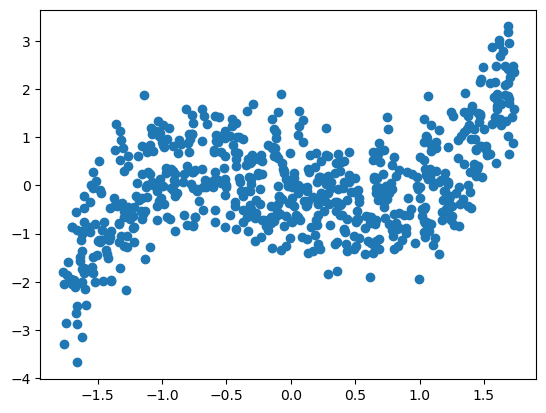

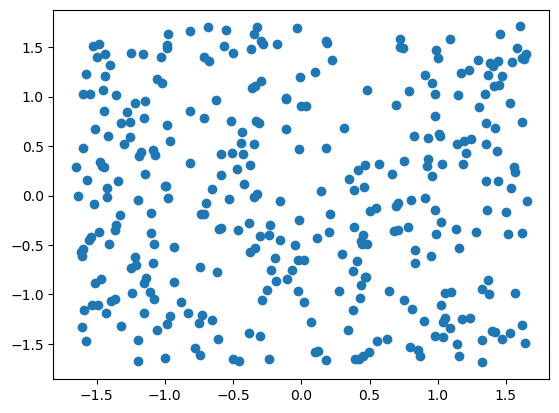

In [11]:
#plotting datasets
plt.plot(df2['x1'],df2['x2'],'o')
plt.show()

plt.plot(df3['x1'],df3['x2'],'o')
plt.show()

## SVMs

In [121]:
#dataset 2 training and optimisation with BayesSearchCV
#train models and use CV to find optimal hyperparameters for model
 
#start clock to measure elapsed time
start = time.time()

# define the search
search = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-2, 1e+2, prior='log-uniform'),
        'kernel': Categorical(['poly','sigmoid','rbf']),
        'degree': Integer(2,4, prior = 'uniform'),
        'gamma': Real(0.001,1, prior = 'log-uniform')
    },
    n_iter=100,
    cv = 3,
    verbose = False
)

# perform the search
search.fit(X2, y2)
# report the best result
print(search.best_score_)
print(search.best_params_)

end = time.time()
time_taken = end - start
print("time taken = {0}".format(time_taken))

C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.7745902733290625
OrderedDict([('C', 15.423802533645935), ('degree', 4), ('gamma', 0.5596892656696214), ('kernel', 'rbf')])
time taken = 318.01079535484314


Accuracy: 0.7820895522388059


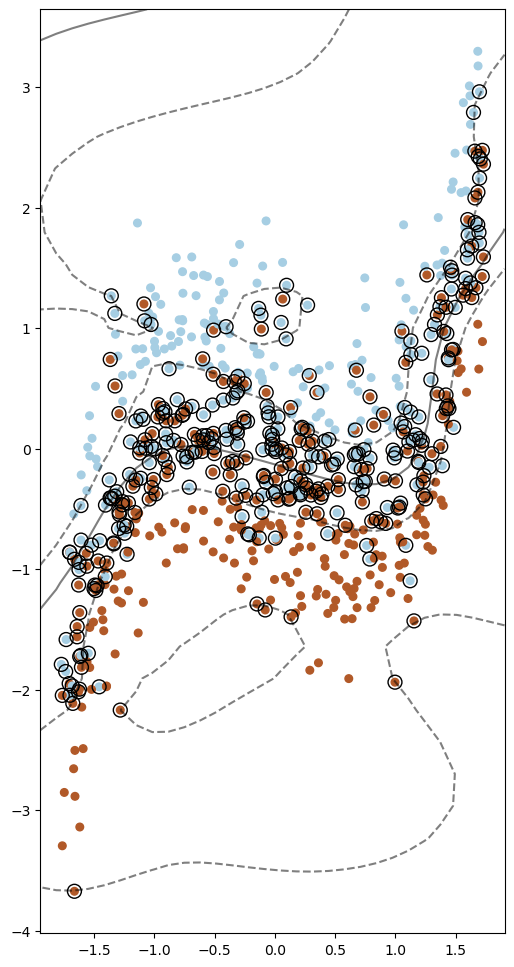

In [54]:
#Dataset 2: train svm
clf_svm2 = svm.SVC(kernel='rbf', C = 15.4238 , gamma = 0.5596892656696214, degree = 4)
clf_svm2.fit(X2, y2)
y_pred2 = clf_svm2.predict(X2)

plt.figure(figsize=(8,12))
plot_margin(X2, y2, clf_svm2)
plt.title("")


print("Accuracy:",metrics.accuracy_score(y2, y_pred2))

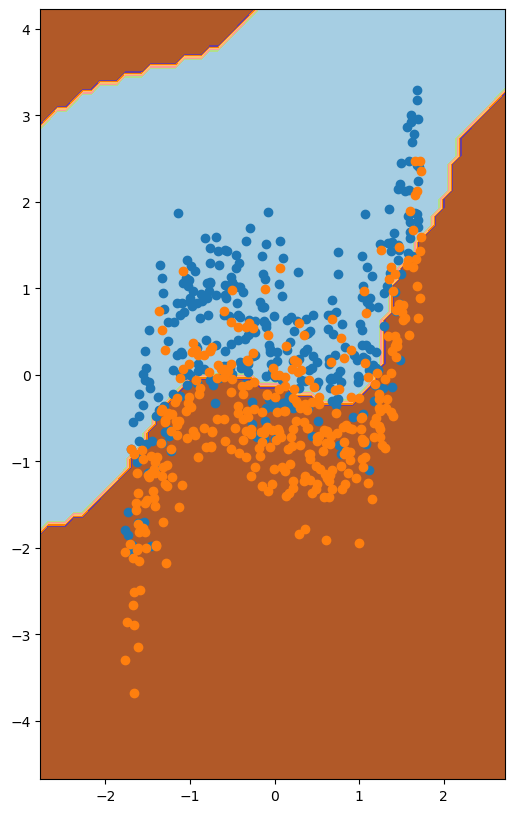

In [123]:
plt.figure(figsize=(6,10))
plot_decisions(X2, y2, clf_svm2)

In [124]:
#dataset 3 training and optimisation with BayesSearchCV
#train models and use CV to find optimal hyperparameters for model
 
#start clock to measure elapsed time
start = time.time()

#define search
search = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-2, 1e+2, prior='log-uniform'),
        'kernel': Categorical(['poly','sigmoid','rbf']),
        'degree': Integer(2,4, prior = 'uniform'),
        'gamma': Real(0.001,1, prior = 'log-uniform')
    },
    n_iter=100,
    cv = 3,
    verbose = False
)

# perform the search
search.fit(X3, y3)
# report the best result
print(search.best_score_)
print(search.best_params_)

end = time.time()
time_taken = end - start
print("time taken = {0}".format(time_taken))

C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anacon

C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Dara\anacon

0.9761100386100386
OrderedDict([('C', 100.0), ('degree', 2), ('gamma', 0.7934065142676966), ('kernel', 'poly')])
time taken = 299.5066568851471


Accuracy: 0.9791044776119403


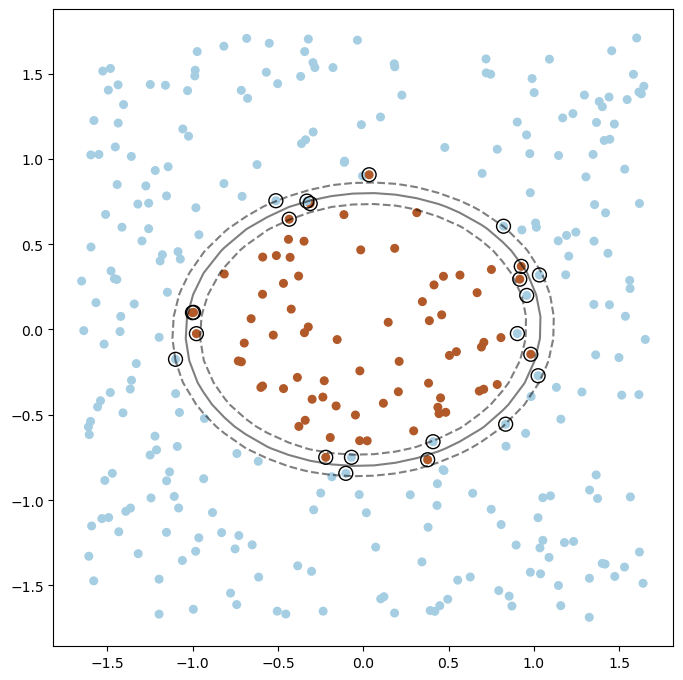

In [127]:
#create plots

clf_svm3 = svm.SVC(kernel='poly', C = 100 , gamma = 0.7934065142676966, degree = 2) 
clf_svm3.fit(X3, y3)
y_pred3 = clf_svm3.predict(X3)

plt.figure(figsize=(8,12))
plot_margin(X3, y3, clf_svm3)
plt.title("")


print("Accuracy:",metrics.accuracy_score(y3, y_pred3))

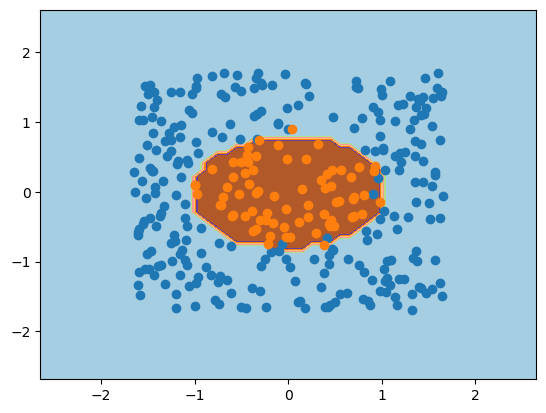

In [128]:
plot_decisions(X3, y3, clf_svm3)

## Learning Curves

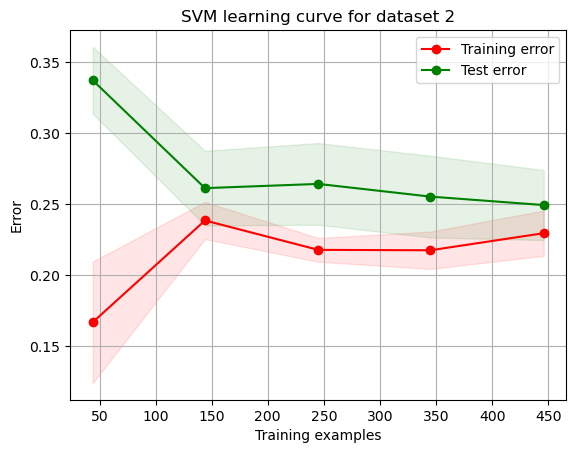

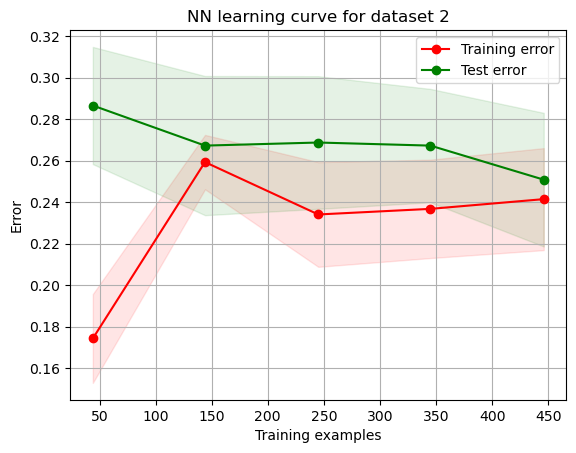

In [129]:
cv = 3


plot_learning_curve(svm.SVC(), "SVM learning curve for dataset 2", X2, y2, ylim=None, cv=cv ,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
plt.title("SVM learning curve for dataset 2")
plt.show()

plot_learning_curve(MLPClassifier(), "Neural Net learning curve for dataset 2", X2, y2, ylim=None, cv=cv ,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
plt.title("NN learning curve for dataset 2")
plt.show()

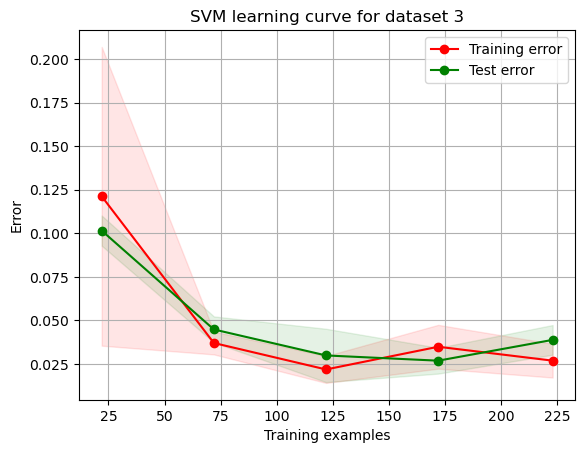

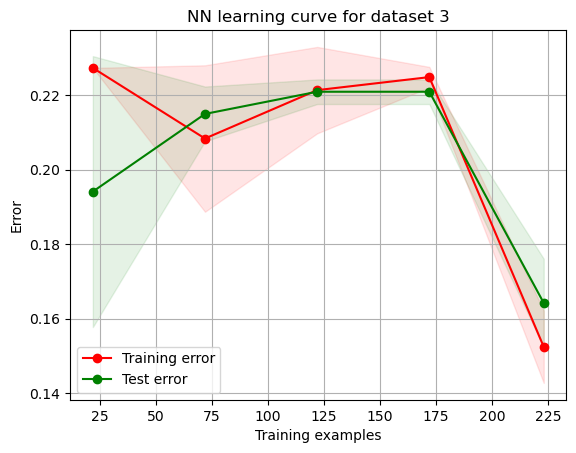

In [130]:
plot_learning_curve(svm.SVC(), "SVM learning curve for dataset 3", X3, y3, ylim=None, cv=cv ,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
plt.title("SVM learning curve for dataset 3")
plt.show()

plot_learning_curve(MLPClassifier(), "Neural Net learning curve for dataset 3", X3, y3, ylim=None, cv=cv ,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
plt.title("NN learning curve for dataset 3")
plt.show()

## Neural Networks

In [58]:
#use Grid search to find optimal parameters for neural network on dataset 2


#dataset2

mlp = MLPClassifier(max_iter = 400)

parameter_space = {
    'hidden_layer_sizes': [(5),(10),(5,2),(20,50),(50,100,30)],
    'learning_rate_init': [0.001, 0.05, 0.1],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['adam', 'lbfgs'],
    'alpha': np.logspace(1e-5, 10, 10), # regularisation
}

start = time.time()

search = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
search.fit(X2, y2)

print(search.best_score_)
print(search.best_params_)

end = time.time()
time_taken = end - start
print("time taken = {0}".format(time_taken))


0.7790345398248985
{'activation': 'relu', 'alpha': 1.0000230261160268, 'hidden_layer_sizes': 5, 'learning_rate_init': 0.05, 'solver': 'lbfgs'}
time taken = 327.01022577285767


Accuracy: 0.7761194029850746


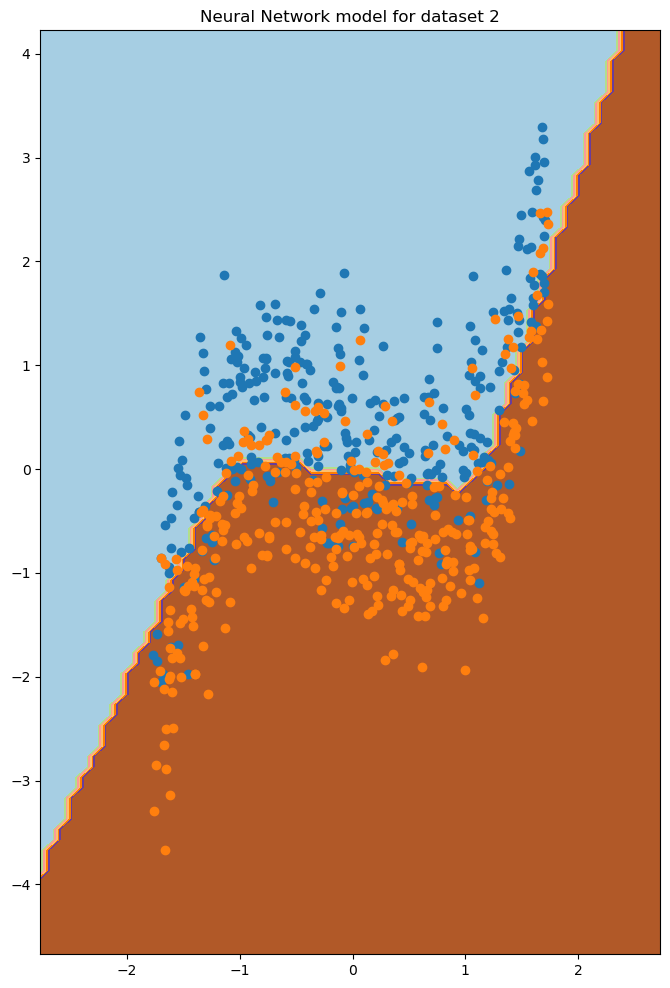

In [74]:
#plot NN model for dataset 2
clf_nn2 = MLPClassifier(solver='lbfgs', alpha=1.0000, hidden_layer_sizes=(5), activation = 'relu' ,learning_rate_init = 0.05 , random_state=1, max_iter = 500)

clf_nn2.fit(X2,y2)
y_prednn = clf_nn.predict(X2)

plt.figure(figsize=(8,12))
plot_decisions(X2, y2, clf_nn2)
plt.title("Neural Network model for dataset 2")


print("Accuracy:",metrics.accuracy_score(y2, y_prednn))


In [42]:
#Bayes Search optimisation of hyperparameters for NN dataset 2 for hidden layer sizes as hyper parameters

start = time.time()

search = BayesSearchCV(estimator=MLPWrapper(),
                    search_spaces= {
                        'layer1': Integer(1, 100),
                        'layer2': Integer(1, 100),
                        },
                    n_iter=10,
                    cv=3, 
                    scoring ='accuracy',
                    return_train_score=True
                    )

search.fit(X2, y2)

print(search.best_score_)
print(search.best_params_)

end = time.time()
time_taken = end - start
print("time taken = {0}".format(time_taken)) 
#reasonable performance by only choosing layer sizes

0.7701259876147768
OrderedDict([('layer1', 18), ('layer2', 34)])
time taken = 28.37214732170105


In [51]:
#neural networks plot for only hidden layer sizes as hyperparameter using bayessearchCV
clf_nn_b = MLPClassifier(hidden_layer_sizes=(18,34))

clf_nn_b.fit(X2,y2)
y_prednn_b = clf_nn_b.predict(X2)

#plt.figure(figsize=(8,12))
#plot_decisions(X2, y2, clf_nn_b)

print("Accuracy:",metrics.accuracy_score(y2, y_prednn_b))


Accuracy: 0.7776119402985074


C:\Users\Dara\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [75]:
#use Grid search to find optimal parameters for neural nets
#dataset3

mlp = MLPClassifier(max_iter = 500)

parameter_space = {
     'hidden_layer_sizes': [(5),(10),(5,2),(20,50),(50,100,30)],
    'learning_rate_init': [0.001, 0.05, 0.1],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['adam', 'lbfgs'],
    'alpha': np.logspace(1e-5, 10, 10), # regularisation
}

start = time.time()

search = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
search.fit(X3, y3)

print(search.best_score_)
print(search.best_params_)

end = time.time()
time_taken = end - start
print("time taken = {0}".format(time_taken))


0.9701040326040326
{'activation': 'tanh', 'alpha': 1.0000230261160268, 'hidden_layer_sizes': (20, 50), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
time taken = 279.342337846756


Accuracy: 0.9701492537313433


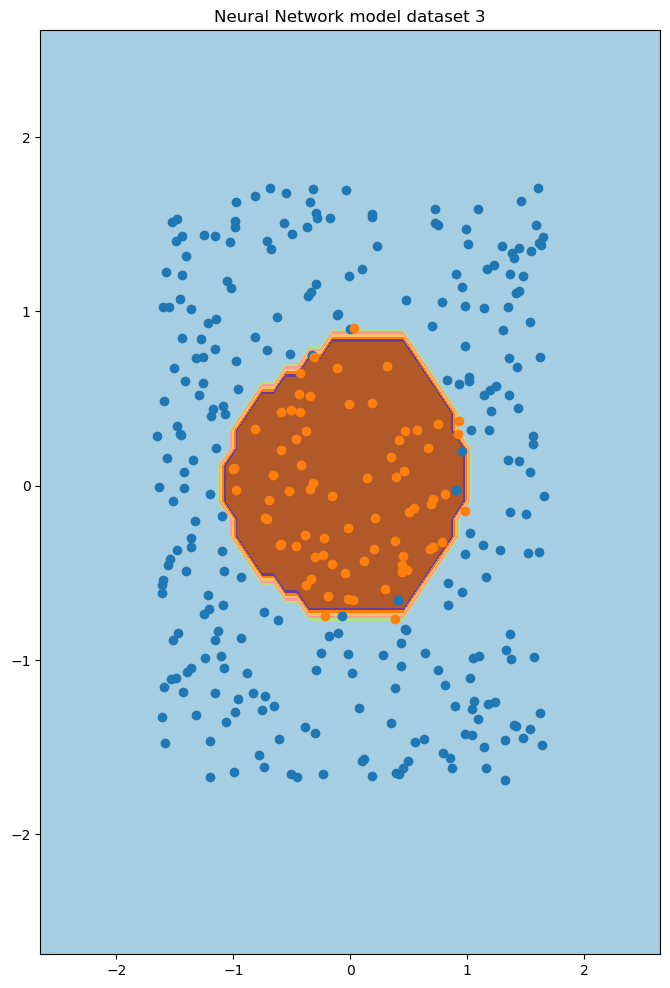

In [91]:
clf_nn3 = MLPClassifier(solver='lbfgs', activation = 'tanh' ,alpha=1.0000230261160268, hidden_layer_sizes=(20,50), random_state=1, learning_rate_init = 0.001 ,max_iter = 400)

clf_nn3.fit(X3,y3)
y_prednn3 = clf_nn3.predict(X3)

plt.figure(figsize=(8,12))
plot_decisions(X3, y3, clf_nn3)
plt.title("Neural Network model dataset 3")


print("Accuracy:",metrics.accuracy_score(y3, y_prednn3))

In [52]:
#get test accuracy
df2t = pd.read_csv('dataset_2_test.csv', names = ['x1','x2','y'])
y2test = df2t['y'].to_numpy()
X2test = df2t[['x1', 'x2']].to_numpy()

df3t = pd.read_csv('dataset_3_test.csv', names = ['x1','x2','y'])
y3test = df3t['y'].to_numpy()
X3test = df3t[['x1', 'x2']].to_numpy()

In [57]:
y_pred_svm2 = clf_svm2.predict(X2test)
print("Accuracy SVM model on dataset2 test: {0:.4f}".format(metrics.accuracy_score(y2test, y_pred_svm2)))

y_pred_nn2 = clf_nn2.predict(X2test)
print("Accuracy Neural Network model on dataset2 test: {0:.4f}".format(metrics.accuracy_score(y2test, y_pred_nn2)))

Accuracy SVM model on dataset2 test: 0.7553
Accuracy Neural Network model on dataset2 test: 0.7825


In [106]:
y_pred_svm3 = clf_svm3.predict(X3test)
print("Accuracy SVM model on dataset3 test: {0:.4f}".format(metrics.accuracy_score(y3test, y_pred_svm3)))

y_pred_nn3 = clf_nn3.predict(X3test)
print("Accuracy Neural Network model on dataset3 test: {0:.4f}".format(metrics.accuracy_score(y3test, y_pred_nn3)))

Accuracy SVM model on dataset3 test: 0.9758
Accuracy Neural Network model on dataset3 test: 0.9697


## Reflection


- The learning curve for the SVM and the Neural Network for dataset 2 are very similar, it appears that Neural Networks performs almost the same as the SVM here.

- There is a greater difference between the learning curves for dataset 3. The errors reduce more quickly for the SVM than they do for the NN as $N$ number of datapoints increases. This suggests that SVMs perform better than Neural Networks for smaller datasets. However it does appear that there is less generalisation error with the Neural Network.

- The Neural Network model achieves greater accuracy than the SVM model for dataset 2 test data. Conversely, for dataset 3 the SVM model achieves greater accuracy on the test data than the Neural Network model. It appears that Neural Networks need more data than SVMS to work well in general from what I have seen from the test errors and the learning curves.

- I focused on Kernels 'rbf', 'poly' and 'sigmoid' when training the SVM model as from looking at the data it appeared that a non-linear kernel was necessary. From playing with the data I found that linear kernel tended to perform poorly and I removed it from the hyperparameter search because it seemed unlikely to give optimal results and also to reduce computation time. The other hyperparameters I looked at were gamma, C (regularisation) and degree. I used BayesSearchCV to find the optimal hyperparameters

- For the Neural Networks I used GridSearchCV with Hyperparameters of hidden-layer size, initial learning rate, alpha (regularization parameter), activation functions of tanh, relu and logistic and solvers adam and lbfgs. The computation times for the Neural Network hyperparameter search were similar to the search times for SVM hyperparameters in general.

- For dataset 2, the neural network had only one hidden layer with 5 hidden nodes, indicating that the model is relatively simple. Then for dataset 3, the optimizer chose a model with 2 hidden layers with size (20,50). This indicates to me that dataset 3 required a more complex neural network model. This model performs worse than the SVM model I trained for this dataset. I imagine this is because Neural Networks with larger hidden layers and nodes (and thus larger complexity) need a greater amount of datapoints $N$ to perform better. There is not a great large observed difference here however with both models performing quite well in both dataset 2 and dataset 3.

- I have seen that SVMs and Neural Networks are very useful models for when working with datasets with non-linear features.

